In [15]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed

In [1]:
# Make data.
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
#print(x)
#print(x.shape)
x, y = np.meshgrid(x,y)
#print(x)
#print(x.shape)

def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4


z = FrankeFunction(x, y)

NameError: name 'np' is not defined

In [2]:
fig = plt.figure()
ax = fig.gca(projection='3d')

# Plot the surface.
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

NameError: name 'plt' is not defined

In [18]:
def CreateDesignMatrix_X(x, y, n = 5):
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)
        
    N = len(x)
    l = int((n+1)*(n+2)/2)
    X = np.ones((N,l))
        
    for i in range(1,n+1):#why range(1, n+1) and not range(n+1)?
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = x**(i-k) * y**k
    return X

In [211]:
n_x = 100   # number of points
m = 5        # degree of polynomial

# sort the random values, else your fit will go crazy
#x = np.sort((np.random.uniform(0, 1, n_x)))
#y = np.sort(np.random.uniform(0, 1, n_x))
x = np.linspace(0, 1, n_x)
y = np.linspace(0, 1, n_x)

# use the meshgrid functionality, very useful
x, y = np.meshgrid(x,y)
z = FrankeFunction(x,y)

#Transform from matrices to vectors
x_1 = np.ravel(x)
y_1 = np.ravel(y)
n = int(len(x_1))
z_1 = np.ravel(z) + np.random.random(n) * 0.0


# finally create the design matrix
X = CreateDesignMatrix_X(x_1, y_1, n=m)


z_1 is the function that gives the data, X is the design matrix

Then inverse the matrix and find β, and perform the linear regression (where ztilde is the model):

In [212]:
beta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(z_1)
ztilde = X @ beta

In [213]:
ztilde.shape

(10000,)

NameError: name 'z_hat' is not defined

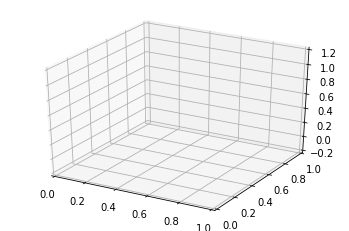

In [214]:
fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
ax1.set_zlim3d(-0.2, 1.2)

ax1.plot_surface(x, y, z_hat, alpha=0.5, cmap=cm.coolwarm)
ax1.scatter(x, y, z, alpha=1, s=0.1, color='black')

plt.title(f'Polynomial degree')
plt.show()

Find the confidence intervals of the parameters β by computing their variances:

In [215]:
np.var(beta)

576.183671768353

?????

Next we evaluate the Mean Squared error (MSE) and the R2 score function for the model (ztilde):

In [216]:
def MSE(z_data, z_model):
    n = np.size(z_data)
    return np.sum((z_data-z_model)**2)/n

#print(MSE(z_1, ztilde))

In [217]:
MSE(np.array([3, 2, 1]), np.array([1]))

1.6666666666666667

The MSE is ideally zero, since the smaller the value the better the fit. Here we observe an MSE of 0.09, which is pretty low, therefore indicating a good fit of the model.

In [218]:
def R2(z_data, z_model):
    return 1 - np.sum((z_data - z_model) ** 2) / np.sum((z_data - np.mean(z_model)) ** 2)

print(R2(z_1, ztilde))

0.9747278335691258


The R2 score gives the coefficient of determination, which indicates how well the model predicts future samples. The best score would be 1.0. Given that the model has a score of 0.5 , this indicates that the model would explain 50% of the future samples correct, which is quite low (not sure if we can say this though).

# Part b) Resampling techniques, adding more complexity

First split the dataset in training data and test data

In [219]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [220]:
X_train, X_test, z_train, z_test = train_test_split(X, z_1, test_size=0.2)

In [221]:
# Get the new model from the training data
beta2 = np.linalg.inv(X_train.T.dot(X_train)).dot(X_train.T).dot(z_train)
ztilde1 = X_train @ beta2

# And the predictions for the test data
zpredict = X_test @ beta2

In [222]:
print("Training MSE:")
print(MSE(z_train, ztilde1))

print("Test MSE:")
print(MSE(z_test, zpredict))

print("Training R2:")
print(R2(z_train, ztilde1))

print("Test R2:")
print(R2(z_test, zpredict))

Training MSE:
0.002054977845013729
Test MSE:
0.0021948774813327666
Training R2:
0.9748489310854709
Test R2:
0.9741193334418518


K-fold cross validation

In [223]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# Initialize a KFold instance
k = 10
kfold = KFold(n_splits = k, shuffle=True)

In [224]:
def cross_validation(x, y, k):
    n = len(x)
    
    indexes = np.arange(y.shape[0])
    np.random.shuffle(indexes)
    x = x[indexes]
    y = y[indexes]
    
    r2_test = []
    mse_test = []
    for i in range(k):
        x_train = np.concatenate((x[:int(i*n/k)], x[int((i + 1)*n/k): ]), axis = 0)
        x_test = x[int(i*n/k):int((i + 1)*n/k)]
        y_train = np.concatenate((y[:int(i*n/k)], y[int((i + 1)*n/k): ]), axis = 0)
        y_test = y[int(i*n/k):int((i + 1)*n/k)]

        beta = np.linalg.inv(x_train.T.dot(x_train)).dot(x_train.T).dot(y_train)
        ytilde = x_train @ beta
        ypredict = x_test @ beta
        
        mse_test.append(MSE(y_test, ypredict))
        r2_test.append(R2(y_test, ypredict))
    
    r2_test = np.array(r2_test)
    mse_test = np.array(mse_test)
    print("R2-Score: %0.3f (+/- %0.3f)" % (r2_test.mean(), r2_test.std() * 2))
    print("MSE-Score: %0.5f (+/- %0.5f)" % (mse_test.mean(), mse_test.std() * 2))
        
    return r2_test, mse_test

In [225]:
r, m = cross_validation(X, z_1, 10)

R2-Score: 0.975 (+/- 0.003)
MSE-Score: 0.00209 (+/- 0.00020)


In [226]:
print(r)

[0.97526873 0.97335057 0.97365767 0.97628273 0.97320815 0.97693745
 0.97101521 0.97621871 0.97400255 0.97519172]


Perform the cross-validation to estimate R2 and MSE

In [227]:
import sklearn.linear_model as skl
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score

In [228]:
linreg = skl.LinearRegression().fit(X_train, z_train)
ztilde2 = linreg.predict(X_test)

In [229]:
scores = cross_val_score(linreg, X_test, z_test, cv = kfold)
print(scores)

[0.97165461 0.97090078 0.97334542 0.97344234 0.97339365 0.97255474
 0.97337577 0.96922357 0.97813472 0.97976978]


In [230]:
print("R2-Score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

R2-Score: 0.97 (+/- 0.01)


In [231]:
scores_mse = cross_val_score(linreg, X_test, z_test, scoring='neg_mean_squared_error', cv=5)

In [232]:
estimated_mse_sklearn = np.mean(-scores_mse)
print(estimated_mse_sklearn)

0.002201992261708418


# Part C) Bias-variance tradeoff

(7500, 1)
(7500, 3)
(7500, 6)
(7500, 10)
(7500, 15)
(7500, 21)
(7500, 28)
(7500, 36)
(7500, 45)
(7500, 55)
(7500, 66)
[]


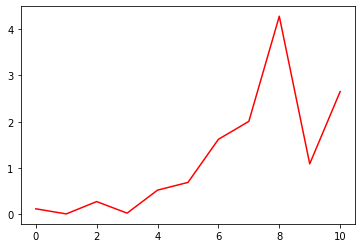

In [256]:
bias_train_scores = []
bias_test_scores = []

degree = 11
s = np.zeros(degree)
error1 = s
error2 = s
error3 = s
error4 = s
for i in range(degree):
    DM = CreateDesignMatrix_X(x_1, y_1, n=i)
    
    DM_train, DM_test, z_1_train, z_1_test = train_test_split(DM, z_1, test_size=0.25, shuffle=False)
    print(DM_train.shape)
    
    beta = np.linalg.inv(DM_train.T.dot(DM_train)).dot(DM_train.T).dot(z_1_train)
    ztilde = DM_train @ beta
    zpredict = DM_test @ beta
    
    #print(R2(z_test, zpredict))
    #print(R2(z_1_test, zpredict))
    
    #error1[i] = np.mean((z_train - ztilde)**2)#, axis=1, keepdims=True) )
    #error2[i] = np.mean((z_test - zpredict)**2)#, axis=1, keepdims=True) )
    error3[i] = np.mean((z_1_train - ztilde)**2)
    error4[i] = np.mean((z_1_test - zpredict)**2)
    
    #bias_train_scores.append(MSE(z_train, np.mean(ztilde)))#np.mean((z_train-np.mean(ztilde)*np.ones(z_train.shape)) ** 2))
    #bias_test_scores.append(MSE(z_test, np.mean(zpredict)))#np.mean((z_test-np.mean(zpredict)*np.ones(z_test.shape)) ** 2))

    
#print(bias_train_scores)
print(bias_test_scores)
#plt.plot(np.arange(10), bias_train_scores, 'r')
#plt.plot(np.arange(10), bias_test_scores, 'b')
#plt.plot(np.arange(degree), error1, 'r', error2, 'b')
plt.plot(np.arange(degree), error3, 'r')#, error4, 'y')
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

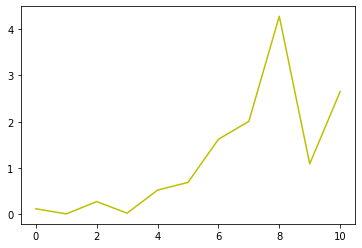

In [257]:
#plt.plot(np.arange(10), error1, 'b')
plt.plot(np.arange(degree), error4, 'y')
plt.show

# Part D) Ridge Regression on the Franke function with resampling

In [27]:
_lambda = 0.8

In [28]:
betaridge = np.linalg.inv(X.T.dot(X)+(_lambda*np.eye(len(X[0])))).dot(X.T).dot(z_1)
zridge = X @ betaridge

In [29]:
print("var(beta)")
print(np.var(beta))

print("var(betaridge)")
print(np.var(betaridge))

var(beta)
7378209.609436751
var(betaridge)
40.98215145042799


In [30]:
print(MSE(z_1, zridge))

0.08653383715083551


In [31]:
print(R2(z_1, zridge))

0.47748893332030307


In [32]:
#not finished

# Part E) Lasso Regression on the Franke function with resampling


In [33]:
from sklearn.preprocessing import PolynomialFeatures

In [34]:
#polynomial_features = PolynomialFeatures(degree=5)
#X_poly = polynomial_features.fit_transform(X)

In [35]:
clf_lasso = skl.Lasso(alpha=0.001).fit(X_train, z_train)
zlasso = clf_lasso.predict(X_test)

In [36]:
print(MSE(z_test, zlasso))

0.08267503498072917


In [37]:
print(R2(z_test, zlasso))

-2.220446049250313e-16


The smaller alpha gets, the lower the MSE and the higher the R2 score.